# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [33]:
import numpy as np
import pandas as pd

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, ParameterGrid, ParameterSampler, RandomizedSearchCV
import missingno as msno
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.utils.fixes import loguniform
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree
from random import randint
import matplotlib.pyplot as plt

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


<AxesSubplot:>

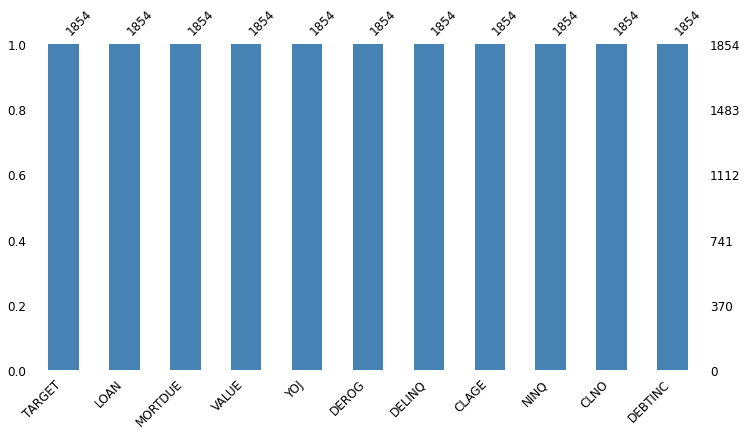

In [4]:
msno.bar(dataset,figsize=(12, 6), fontsize=12, color='steelblue')

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

1. Es un conjunto de datos de préstamos basados en Kaggle Home Equity
2. El (BAD) es una variable binaria que indica si un solicitante eventualmente incurrió en incumplimiento o fue gravemente moroso.
3. Atributos:
- TARGET: Label: 1 = cliente incumplidor con el préstamo - 0 = préstamo reembolsado
- LOAN: Monto de la solicitud de préstamo
- MORTDUE: Monto adeudado de la hipoteca existente
- VALUE: Valor de la propiedad actual
- YOJ Años en el trabajo actual
- DEROG Número de informes despectivos importantes
- DELINQ Número de líneas de crédito morosas
- CLAGE Edad de la línea comercial más antigua en meses
- NINQ Número de líneas de crédito recientes
- CLNO Número de líneas de crédito
- DEBTINC Relación deuda-ingresos
4. Los atributos determinantes para la predicción pueden ser: LOAN, DEBTINC

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy: (proporcion de ejemplos bien clasificados dividido el total de muestras del conjunto)
- Precision: es la proporción de positivos propuestos por el modelo que fueron correctos (fraccion de predicciones correctas de la clase + sobre el total de predicciones +)
- Recall: es la proporción de positivos correctos que fueron encontrados por el modelo (% de puntos que predije ccomo + sobre el total de +)
- F1: (media armonica de precision y recall. Va a tener un valor alto si precision y recall tienen un num alto)
- matriz de confusión

In [5]:
# Entrenar el modelo
clf = SGDClassifier(random_state=100)
clf.fit(X_train, y_train)

SGDClassifier(random_state=100)

In [6]:
# Predicción 
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [7]:
# Evaluar
accuracy = accuracy_score(y_test, y_test_pred)
print(f'accuracy = {accuracy}')
precision = precision_score(y_test, y_test_pred, zero_division=1) # va 0 o 1??
print(f'precision = {precision}')
recall = recall_score(y_test, y_test_pred)
print(f'recall = {recall}')
f1_score_ = f1_score(y_test, y_test_pred)
print(f'f1_score = {f1_score_}')

accuracy = 0.8436657681940701
precision = 1.0
recall = 0.0
f1_score = 0.0


### Matriz de Confusión
- True Positive (TP): observation is positive, and is predicted to be positive.
- False Negative (FN): observation is positive, but is predicted negative.
- True Negative (TN): observation is negative, and is predicted to be negative.
- False Positive (FP): observation is negative, but is predicted positive.

In [8]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_test_pred)
print(f'matriz_confusion = {matriz_confusion}')

matriz_confusion = [[313   0]
 [ 58   0]]


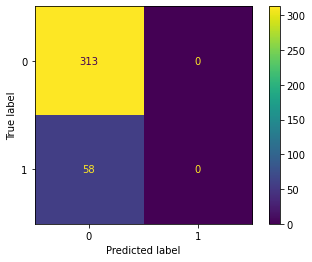

In [9]:
plot_confusion_matrix(clf, X_test, y_test)   

Label: 
- 1 = cliente incumplidor con el préstamo 
- 0 = préstamo reembolsado

Según el modelo, 313 son los tomadores de préstamos que reembolsaron su deuda y es correcto. (TP)

58 son los tomadores de préstamos que reembolsaron su deuda y en realidad son clienters inclumplidores. (FP)

In [24]:
# Probamos normalizando

# Entrenamos el modelo
clf_2 = make_pipeline(StandardScaler(), SGDClassifier(random_state=100))
clf_2.fit(X_train, y_train)

# Predecimos
y_train_pred_2 = clf_2.predict(X_train)
y_test_pred_2 = clf_2.predict(X_test)

# Evaluamos
accuracy_n = accuracy_score(y_test, y_test_pred_2)
print(f'accuracy = {accuracy_n}')
precision_n = precision_score(y_test, y_test_pred_2, zero_division=1) # va 0 o 1??
print(f'precision = {precision_n}')
recall_n = recall_score(y_test, y_test_pred_2)
print(f'recall = {recall_n}')
f1_score_n = f1_score(y_test, y_test_pred_2, zero_division=1)
print(f'f1_score = {f1_score_n}')

accuracy = 0.8814016172506739
precision = 0.85
recall = 0.29310344827586204
f1_score = 0.4358974358974359


In [25]:
# Matriz de confusión
matriz_confusion_2 = confusion_matrix(y_test, y_test_pred_2)
print(f'matriz_confusion = {matriz_confusion_2}')

matriz_confusion = [[310   3]
 [ 41  17]]


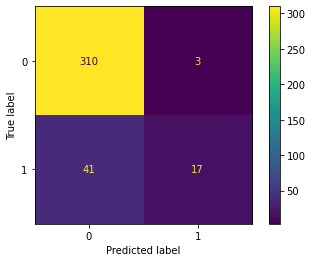

In [12]:
plot_confusion_matrix(clf_2, X_test, y_test)

Label: 
- 1 = cliente incumplidor con el préstamo 
- 0 = préstamo reembolsado

Según el modelo, 310 son los tomadores de préstamos que reembolsaron su deuda y es correcto. (TP)

41 son los tomadores de préstamos que reembolsaron su deuda y en realidad son clienters inclumplidores. (FP)

3 son clientes incumplidores que en realidad reembolsaron su deuda. (FN)

17 son tomadores de préstamos incumplidores y es correcto. (TN)

### Modelo Normalizado
-    accuracy = 0.8436657681940701
-    precision = 0.85
-    recall = 0.29310344827586204
-    f1_score = 0.4358974358974359

### Modelo Sin Normalizar
-    accuracy = 0.8814016172506739
-    precision = 1.0
-    recall = 0.0
-    f1_score = 0.0

“Precision” se refiere a lo cerca que está el resultado de una medición del valor verdadero: 

### TERMINAR DE ARMAR


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

entre 8 y 27 modelos. 



Seleccion de hiperparametros: los que hacen mi accurany estimate mas alto (lo menos sesgado)

In [15]:
param_grid = {
    'loss': [ 'hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'learning_rate': ['optimal','constant','invscaling','adaptive'],
    'alpha':loguniform(1e-1, 1e2),
    'penalty':['l2', 'l1', 'elasticnet']
}

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [17]:
# Entrenar el modelo
clf_tree = DecisionTreeClassifier(random_state=100)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

In [19]:
# Predicción 
y_train_pr_tree = clf_tree.predict(X_train)
y_test_pr_tree = clf_tree.predict(X_test)

In [20]:
# Evaluar
accuracy_t = accuracy_score(y_test, y_test_pr_tree)
print(f'accuracy = {accuracy_t}')
precision_t = precision_score(y_test, y_test_pr_tree, zero_division=1) # va 0 o 1??
print(f'precision = {precision_t}')
recall_t = recall_score(y_test, y_test_pr_tree)
print(f'recall = {recall_t}')
f1_score_t = f1_score(y_test, y_test_pr_tree)
print(f'f1_score = {f1_score_t}')

accuracy = 0.9056603773584906
precision = 0.7169811320754716
recall = 0.6551724137931034
f1_score = 0.6846846846846846


In [22]:
# Matriz de confusión
matriz_confusion_t = confusion_matrix(y_test, y_test_pr_tree)
print(f'matriz_confusion = {matriz_confusion_t}')

matriz_confusion = [[298  15]
 [ 20  38]]


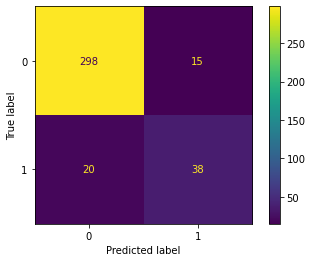

In [23]:
plot_confusion_matrix(clf_tree, X_test, y_test)   

Label: 
- 1 = cliente incumplidor con el préstamo 
- 0 = préstamo reembolsado

Según el modelo, 298 son los tomadores de préstamos que reembolsaron su deuda y es correcto. (TP)

20 son los tomadores de préstamos que reembolsaron su deuda y en realidad son clientes inclumplidores. (FP)

15 son clientes incumplidores que en realidad reembolsaron su deuda. (FN)

38 son tomadores de préstamos incumplidores y es correcto. (TN)

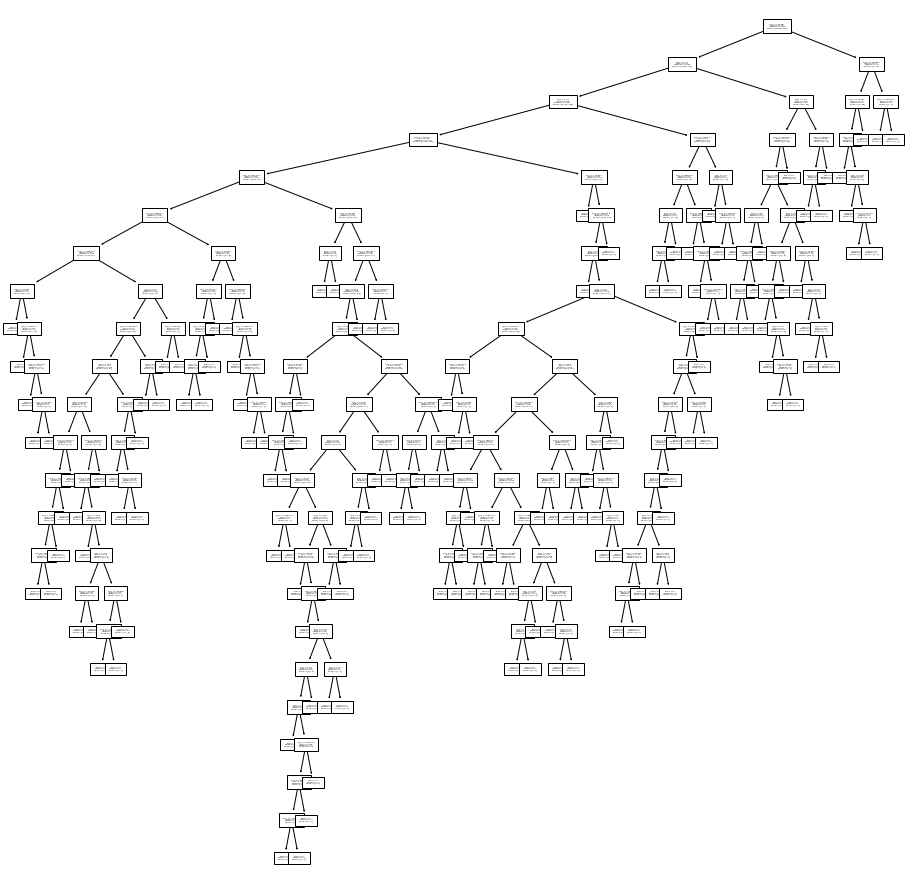

In [38]:
plt.figure(figsize=(16,16))
plot_tree(clf_tree, fontsize=2);

In [26]:
# Probamos normalizando

# Entrenamos el modelo
clf_tree2 = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=100))
clf_tree2.fit(X_train, y_train)

# Predecimos
y_train_pr_2 = clf_tree2.predict(X_train)
y_test_pr_2 = clf_tree2.predict(X_test)

# Evaluamos
accuracy_tn = accuracy_score(y_test, y_test_pr_2)
print(f'accuracy = {accuracy_tn}')
precision_tn = precision_score(y_test, y_test_pr_2, zero_division=1) # va 0 o 1??
print(f'precision = {precision_tn}')
recall_tn = recall_score(y_test, y_test_pr_2)
print(f'recall = {recall_tn}')
f1_score_tn = f1_score(y_test, y_test_pr_2, zero_division=1)
print(f'f1_score = {f1_score_tn}')

accuracy = 0.9056603773584906
precision = 0.7169811320754716
recall = 0.6551724137931034
f1_score = 0.6846846846846846


In [27]:
# Matriz de confusión
matriz_confusion_tn = confusion_matrix(y_test, y_test_pr_2)
print(f'matriz_confusion = {matriz_confusion_tn}')

matriz_confusion = [[298  15]
 [ 20  38]]


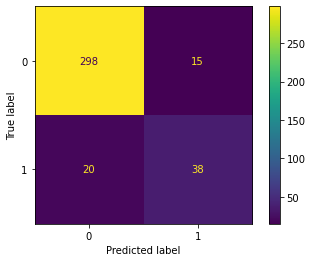

In [28]:
plot_confusion_matrix(clf_tree2, X_test, y_test)   

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html